#https://nbviewer.org/github/SheffieldML/notebook/blob/master/GPy/coregionalized_regression_tutorial.ipynb

In [1]:
#%pylab inline
#import pylab as pb
#pylab.ion()
import GPy

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
#This functions generate data corresponding to two outputs
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:,None] * 2.
f_output2 = lambda x: 6. * np.cos(x/5.) + .2*x + 35. + np.random.rand(x.size)[:,None] * 8.


#{X,Y} training set for each output
X1 = np.random.rand(100)[:,None]; X1=X1*75
X2 = np.random.rand(100)[:,None]; X2=X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
#{X,Y} test set for each output
Xt1 = np.random.rand(100)[:,None]*100
Xt2 = np.random.rand(100)[:,None]*100
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)

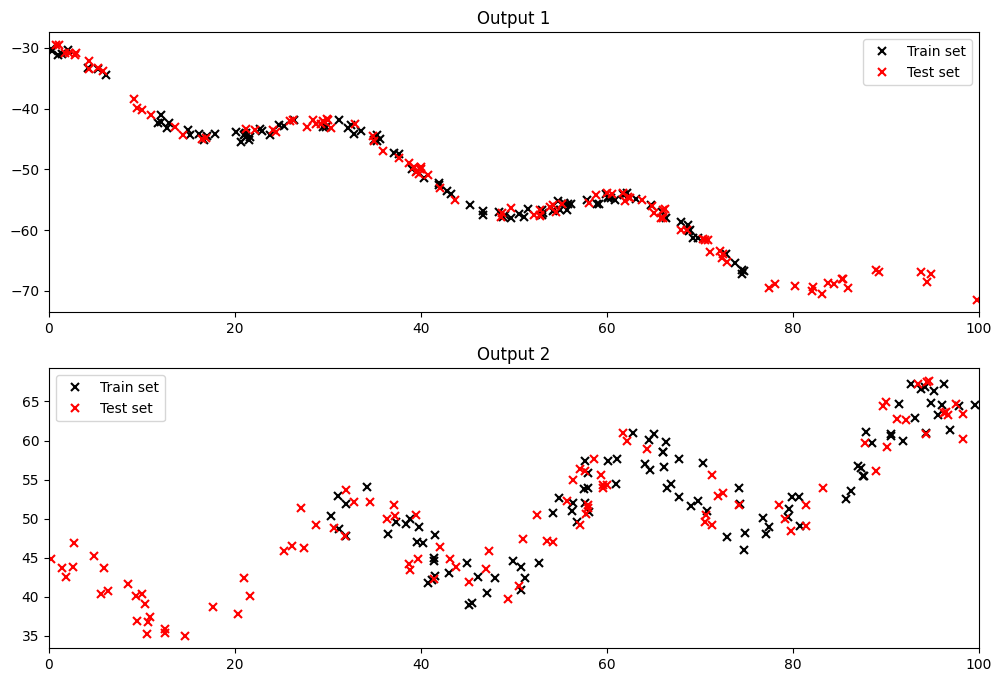

In [3]:
xlim = (0,100); ylim = (0,50)
fig = pb.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.set_xlim(xlim)
ax1.set_title('Output 1')
ax1.plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.set_xlim(xlim)
ax2.set_title('Output 2')
ax2.plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5,label='Test set')
ax2.legend()

In [6]:
def plot_2outputs(m,xlim,ylim):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,100),ax=ax1)
    ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(100,200),ax=ax2)
    ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)

In [7]:
K=GPy.kern.RBF(1)
B = GPy.kern.Coregionalize(input_dim=1,output_dim=2) 
multkernel = K.prod(B,name='B.K')
print(multkernel)

  B_K.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  coregion.W       |  (2, 1)  |               |        
  coregion.kappa   |    (2,)  |      +ve      |        


In [8]:
icm = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=GPy.kern.RBF(1))
print (icm)

  ICM.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  B.W              |  (2, 1)  |               |        
  B.kappa          |    (2,)  |      +ve      |        


In [21]:
X1.shape

(100, 1)


Name : gp
Objective : 363.20197037717895
Number of Parameters : 8
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                    |                value  |  constraints  |  priors
  ICM.Mat32.variance                     |                  1.0  |   +ve fixed   |        
  ICM.Mat32.lengthscale                  |    242.4851436910002  |      +ve      |        
  ICM.B.W                                |               (2, 1)  |               |        
  ICM.B.kappa                            |                 (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |  0.26408157939609833  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |    4.920864604653497  |      +ve      |        


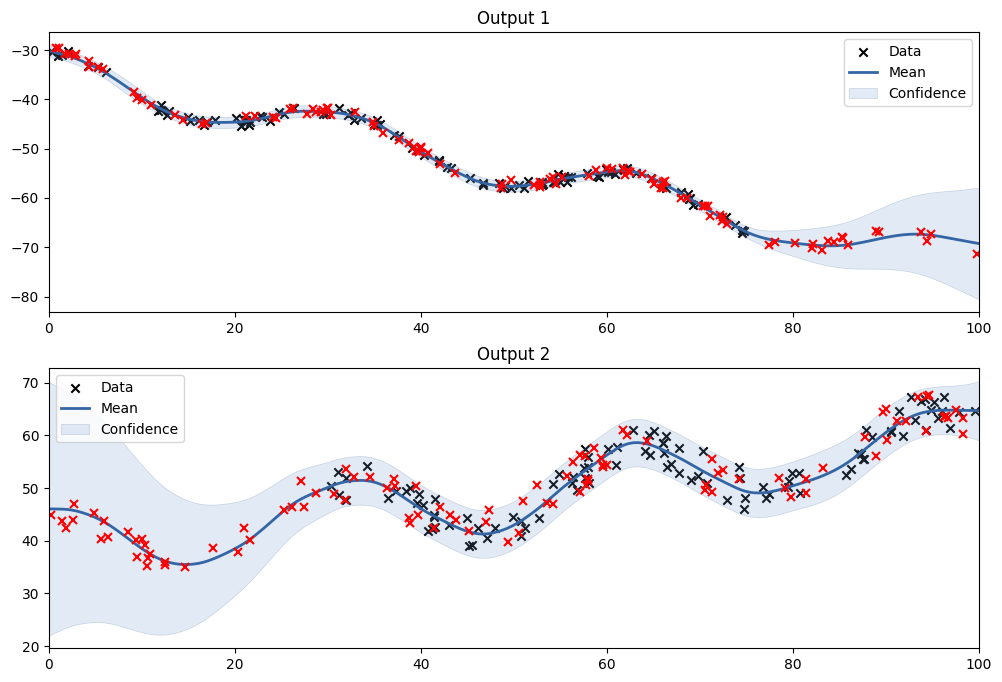

In [9]:
K = GPy.kern.Matern32(1)
icm = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=K)

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2],kernel=icm)
m['.*Mat32.var'].constrain_fixed(1.) #For this kernel, B.kappa encodes the variance now.
m.optimize()
print(m)
plot_2outputs(m,xlim=(0,100),ylim=(-20,60))

Text(0.5, 1.0, 'Output 2')

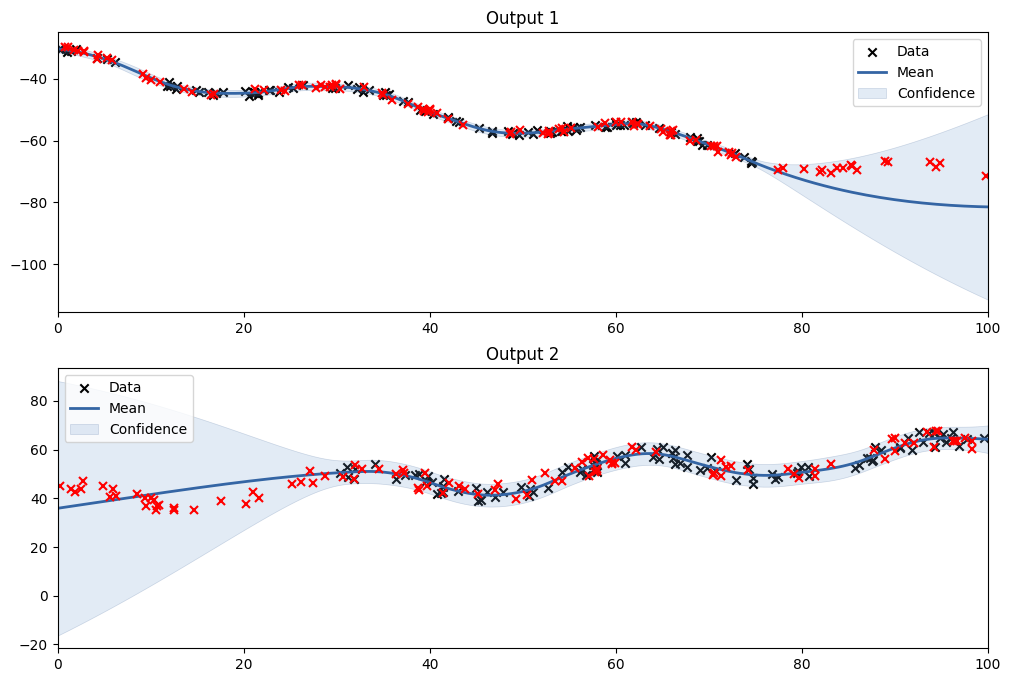

In [10]:
K = GPy.kern.Matern32(1)

m1 = GPy.models.GPRegression(X1,Y1,kernel=K.copy())
m1.optimize()
m2 = GPy.models.GPRegression(X2,Y2,kernel=K.copy())
m2.optimize()
fig = pb.figure(figsize=(12,8))
#Output 1
ax1 = fig.add_subplot(211)
m1.plot(plot_limits=xlim,ax=ax1)
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
ax1.set_title('Output 1')
#Output 2
ax2 = fig.add_subplot(212)
m2.plot(plot_limits=xlim,ax=ax2)
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)
ax2.set_title('Output 2')

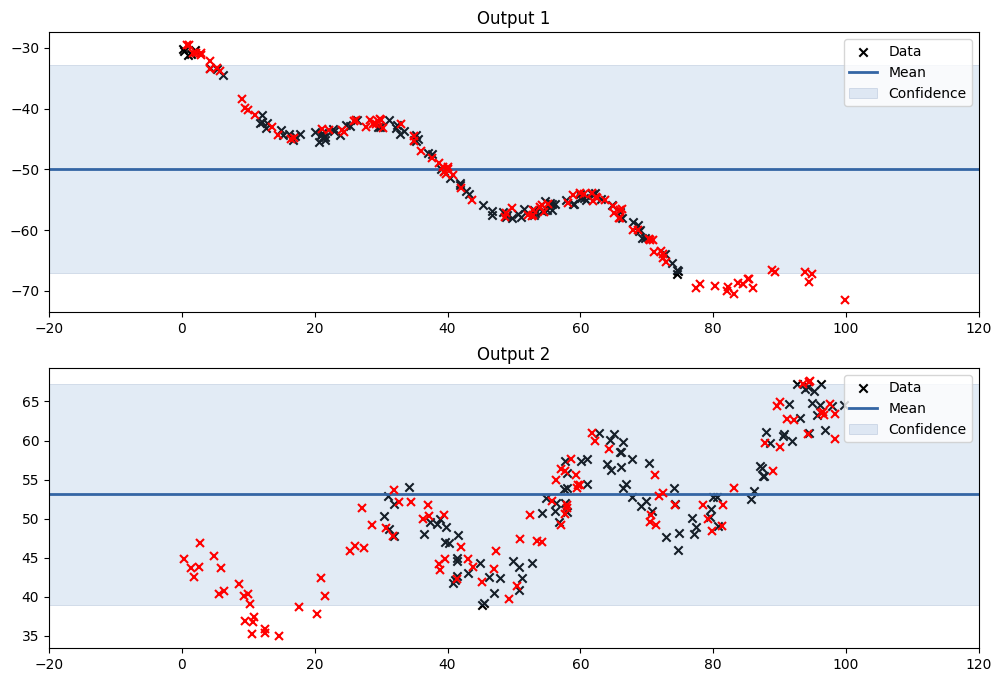

In [11]:
kernel = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=GPy.kern.Bias(input_dim=1))
m = GPy.models.GPCoregionalizedRegression(X_list=[X1,X2],Y_list=[Y1,Y2],kernel=kernel)
m['.*bias.var'].constrain_fixed(1) #B.kappa now encodes the variance.
m['.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,xlim=(-20,120),ylim=(0,60))

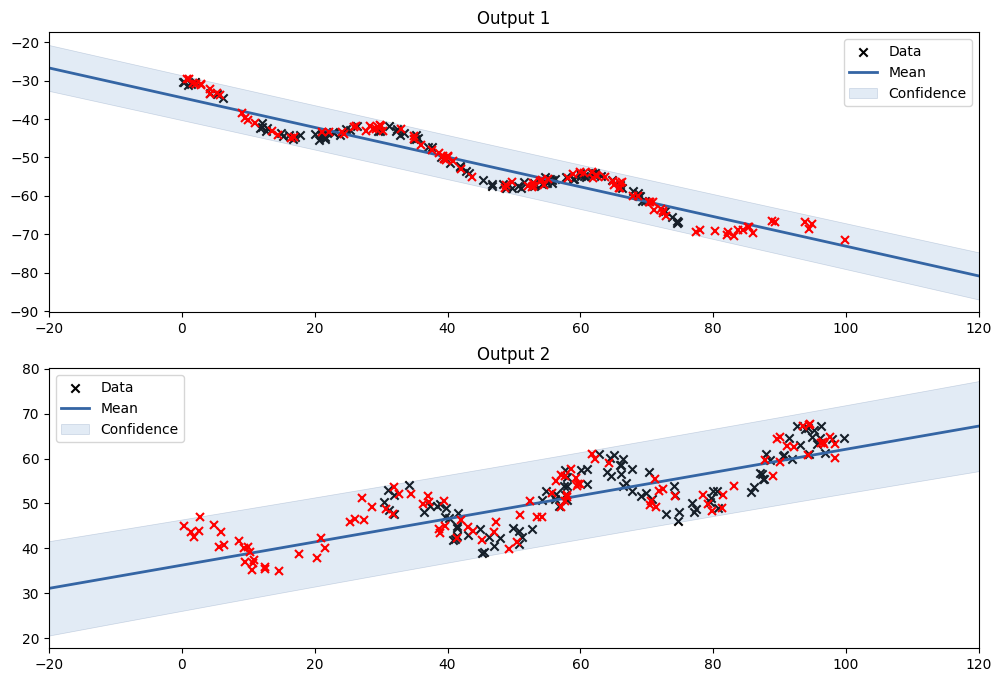

In [12]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2])

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2],kernel=lcm)
m['.*bias.var'].constrain_fixed(1.)
m['.*W'].constrain_fixed(0)
m['.*linear.var'].constrain_fixed(1.)
m.optimize()
plot_2outputs(m,xlim=(-20,120),ylim=(0,60))

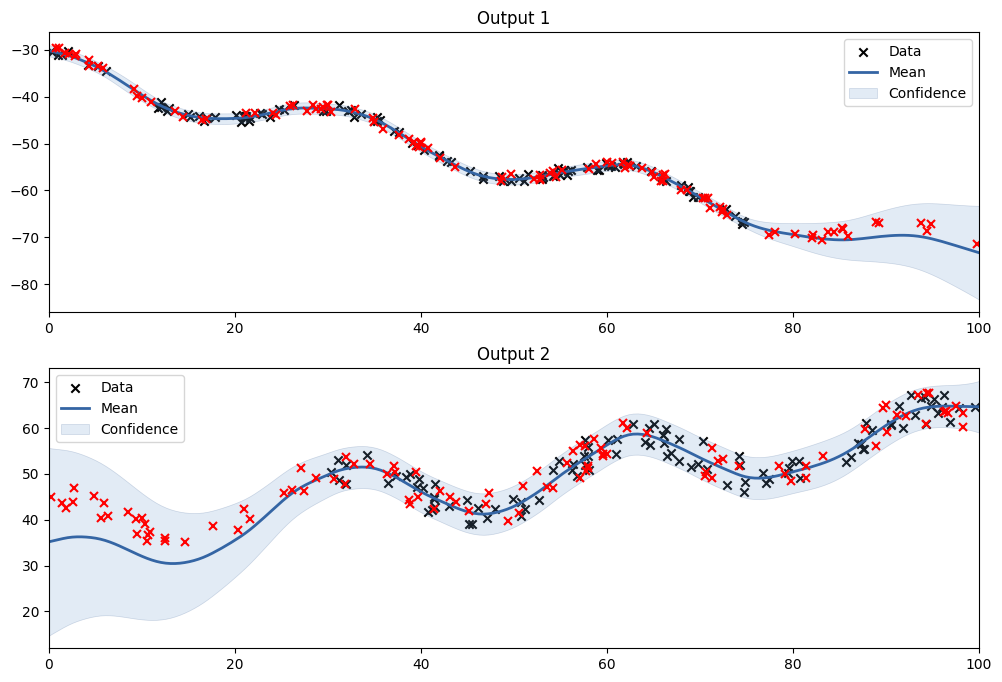

In [13]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
K3 = GPy.kern.Matern32(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2,K3])

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2],kernel=lcm)
m['.*ICM.*var'].unconstrain()
m['.*ICM0.*var'].constrain_fixed(1.)
m['.*ICM0.*W'].constrain_fixed(0)
m['.*ICM1.*var'].constrain_fixed(1.)
m['.*ICM1.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,xlim=(0,100),ylim=(-20,60))

In [14]:
newX = np.arange(100,110)[:,None]
newX = np.hstack([newX,np.ones_like(newX)])
print(newX)

[[100   1]
 [101   1]
 [102   1]
 [103   1]
 [104   1]
 [105   1]
 [106   1]
 [107   1]
 [108   1]
 [109   1]]


In [15]:
noise_dict = {'output_index':newX[:,1:].astype(int)}

In [16]:
m.predict(newX,Y_metadata=noise_dict)

(array([[64.61890785],
        [64.5633816 ],
        [64.50274894],
        [64.43711521],
        [64.36658414],
        [64.29125793],
        [64.21123725],
        [64.12662123],
        [64.03750754],
        [63.94399237]]),
 array([[  8.21579561],
        [ 10.7157835 ],
        [ 14.5598816 ],
        [ 20.02339474],
        [ 27.36398462],
        [ 36.82237762],
        [ 48.62304937],
        [ 62.97488658],
        [ 80.07182699],
        [100.09347799]]))

In [18]:
m.predict(X1)

IndexError: index 1 is out of bounds for axis 1 with size 1